In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 
import networkx as nx
import math 
from collections import defaultdict

import warnings
warnings.filterwarnings('ignore')

### Miscellanous



Experiences on Independent Cascades

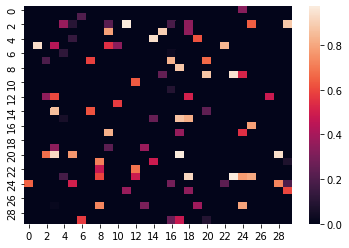

In [ ]:
nV = 30
nT = 30
pEdge = 0.1
theta_ex = np.random.uniform(0,1,(nV,nT))
mask = np.random.binomial(1,pEdge,(nV,nT))
theta_ex = theta_ex * mask
sns.heatmap(theta_ex)


In [ ]:
def createIndependentCascade(S, nb_cascade, theta):
    """creates multiple independent cascades following theta probability 
    input : 
        S seeds
    output : 
        "parents" array(nb_cascade, V) representing the DAG of each cascades
    """
    nb_V = theta.shape[0]

    parent = np.empty(shape=(nb_cascade,nb_V))
    parent[:] = np.nan
    for s in S : 
        parent[:, s] = s

    vertices = np.arange(0,nb_V)
    
    for c in range(nb_cascade):
        
        to_process = S.copy() #list assignments in python are only assigning pointers

        while len(to_process) > 0 :
            s = to_process.pop(0) #Queue
            activations = np.random.uniform(high = 1, size = nb_V) < theta[s, :]
            activated = vertices[activations]
            
            for v in activated :
                if parent[c,v] != parent[c,v] :
                    parent[c,v] = s
                    to_process.append(v)


    return parent

parents = createIndependentCascade([0, 7], 3, theta_ex)

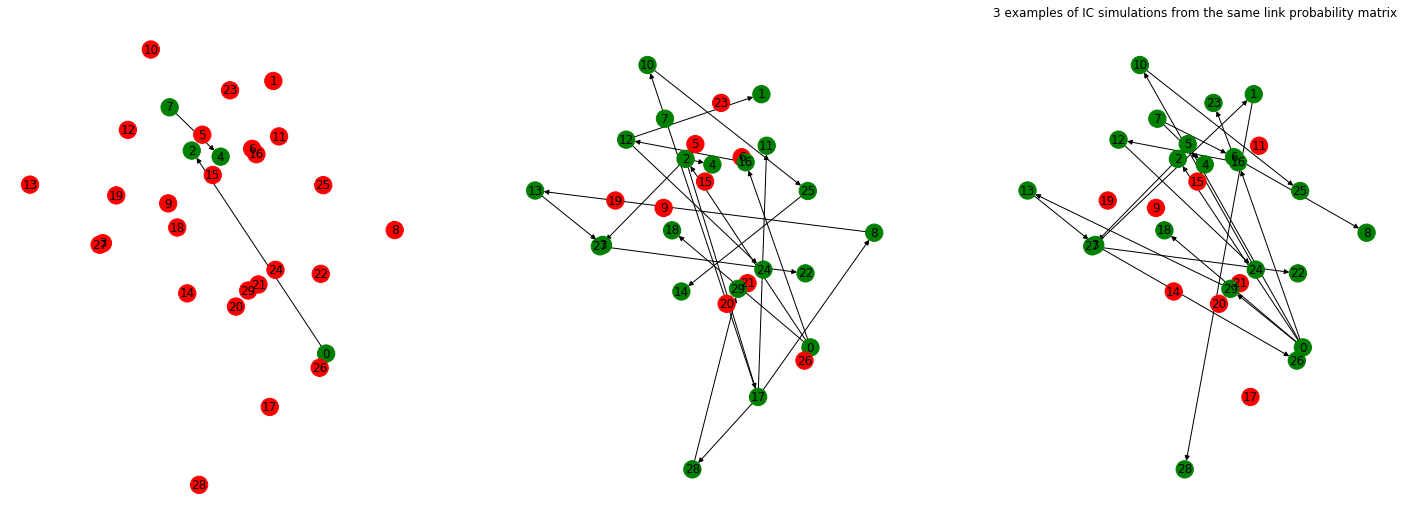

In [ ]:

def graphCascade(parents, k) :
    """Returns the DAG associated with the kth line of parents"""
    
    nbV = parents.shape[1]

    G = nx.DiGraph()
    G.add_nodes_from(list(range(nbV)))

    for i in range(nbV) :
        if parents[k, i] == parents[k, i] : 
            G.add_edge(parents[k,i], i)
    
    return G

def drawCascades(parents, nrows, ncols ) :
    fig, axes = plt.subplots(nrows, ncols, figsize = (nrows * 25, ncols * 3))
    color_map = np.vectorize(lambda x : 'red' if math.isnan(x) else 'green' )(parents)

    G = nx.DiGraph(theta_ex)
    pos = nx.kamada_kawai_layout(G)#graphviz_layout(G, prog="twopi")
    
    for k in range(0,parents.shape[0]):
        
        G = graphCascade(parents, k)
        nx.draw(G,with_labels = True, pos = pos, ax=axes[k], node_color = list(color_map[k]))

    plt.title(f"{parents.shape[0]} examples of IC simulations from the same link probability matrix ")
    plt.show()

drawCascades(parents, 1,3)

Power law graphs 

In [ ]:
def exports_graph_power_law() :
    """
    exports a dense graph with edge weights following a power law
    """
    A = np.random.uniform(0,1,(100,100))
    weights = -np.log(A)

    G = nx.DiGraph(weights)
    nx.write_gexf(G, "graphs/weighted_100.gexf")


### Twitter dataset
Loading the data : 

In [2]:
%%time

df_retweets = pd.read_csv("data/retweetsranked_full.csv", 
    sep = ';', 
    #chunksize=1000, 
    nrows=  1000000,
    header=None, 
    names=["RT", "Date", "User1", "User2", "Orig"], 
    parse_dates=["Date"], 
    dtype={"User1" : np.int32, "User2": np.int32})


df_texts = pd.read_csv("data/retweetstext.csv", 
    sep = "#1#8#3#", 
    nrows= 1000, 
    header=None, 
    names = ['RT', 'Text', "Date", "User1", "User2", "Orig"],
    parse_dates=['Date'],
    dtype={"User1" : np.int32, "User2": np.int32})

#contains 301M edges
df_graph = pd.read_csv("data/graph_twitter_full.csv", 
    nrows=1000000,
    #nrows=10, 
    header=None, 
    names = ['u', 'v'],
    dtype={"u": np.int32, "v":np.int32})


CPU times: total: 1.61 s
Wall time: 2.42 s


Distribution of number of rts : power law

In [3]:
%%time
df_gb_User1 = df_retweets[['User1','User2']]\
    .groupby('User1')\
        .agg({'User2': [list, 'count']})\
            .reset_index()
df_gb_User1.sort_values(("User2",'count'), ascending=False)

KeyboardInterrupt: 

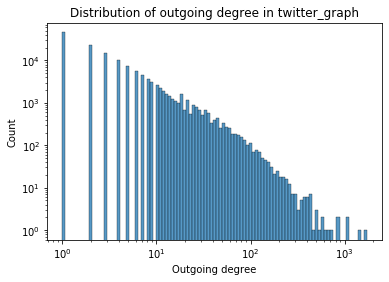

In [28]:
sns.histplot(df_gb_User1[('User2','count')], log_scale=(10,10))
plt.Line2D(xdata=[1, 1000], ydata=[5000, 0])

plt.title("Distribution of outgoing degree in twitter_graph")
plt.xlabel("Outgoing degree")
plt.show()

In [7]:

def export_graph_first_k_users(k):
    """
    creates the graph containing all retweets of k first users (if k < 6900, the first 1M rows of df_retweets are enough)
    and exports it in graph/firstkuser.gexf
    """
    df = df_graph[df_graph['u'] < k]
    G=nx.DiGraph()
    for (u,v) in zip(df['u'], df['v']) :
        G.add_edge(u,v)
        G.nodes[u]['Role'] = 'Influencer'
        
    nx.write_gexf(G, f"graphs/first{k}user.gexf")
#export_graph_first_k_users(100)

In [6]:
%%time

def createStatisticsPickle() :
    """
    loads the data of statistics.txt in a pandas dataframe
    and stores it in data/statistics.pkl

    Normally runs in 20s for 8M lines 
    """
    with open('results/statistics.txt', 'r') as file :

        headers = file.readline().split()
        d = {}
        for header in headers :
            d[header] = []
        i=0
        for line in file.readlines() :
            if i%500000 == 0 :
                print(f"{i}th line. ")
            line = line.split()

            d[headers[0]].append(int(line[0]))
            d[headers[1]].append(int(line[1]))
            d[headers[2]].append(int(line[2]))
            if len(line) > 3 :
                d[headers[3]].append(line[3])
            else : 
                d[headers[3]].append('')

            i += 1
        df_stat = pd.DataFrame(d)
        df_stat.to_pickle("data/statistics.pkl")

CPU times: total: 0 ns
Wall time: 0 ns


Subsampling of RTs with tweets having more than n RTs

In [4]:
%%time
"""
df_orig : Counts the number of rts each original tweet has
"""
df_orig = df_retweets.groupby('Orig').agg({'RT' : 'count', 'User1' : list, 'User2' : 'first'})
df_orig = df_orig.sort_values('RT')


CPU times: total: 56.9 s
Wall time: 57 s


In [13]:
n_min_retweets = 5
df_orig_k = df_orig[df_orig['RT']>n_min_retweets]

list_target = list(set(df_orig_k.User1.sum()))
list_infl = list(df_orig_k.User2.unique())

print(f"""Summary : \n - {df_retweets.shape[0]} retweets processed 
- Concerning {df_orig.shape[0]} original tweets 
- Among which {df_orig_k.shape[0]} have more than {n_min_retweets} retweets
- Only considering these tweets : There are {len(list_infl)} influencers and {len(list_target)} targets 
- which represent {len(list_infl) / len(list(df_retweets.User2.unique())) * 100}% of influencers and {len(list_target) / len(list(df_retweets.User1.unique())) * 100}% of targets""")

Summary : 
 - 1000000 retweets processed 
- Concerning 846139 original tweets 
- Among which 6145 have more than 5 retweets
- Only considering these tweets : There are 1435 influencers and 38778 targets 
- which represent 0.503069248270809% of influencers and 26.96718290367671% of targets


In [14]:
df_retweets_filtered = df_retweets.merge(df_orig_k, on=['Orig', 'User2'], how='inner')
df_retweets_filtered.drop(columns=['User1_y'], inplace = True, ) # access this info in df_orig_k
df_retweets_filtered.columns = ['RT', 'Date','User1','User2','Orig', 'nRtOrig']

df_User12 = df_retweets_filtered.groupby(['User1','User2']).agg({'RT': 'count'}).reset_index()
df_User12.columns = ['User1','User2','weightEdge']

df_retweets_filtered = df_retweets_filtered.merge(df_User12, on = ['User1','User2'])

print("df_retweets_filtered : contains only the retweets with original tweet having more than n rts, the number of rt it has, the list of the rts it provoqued")
df_retweets_filtered
#df_retweets_filtered.to_pickle("data/df_retweets_filtered.pkl")


df_retweets_filtered : contains only the retweets with original tweet having more than n rts, the number of rt it has, the list of the rts it provoqued


In [77]:
def export_filtered() :
    
    """
    Export the weighted graph of users with edge weight = nb of User1's retweets of tweets of user 2
    only considers tweets with more than n_min_retweets rts
    """

    G = nx.DiGraph()
    G.add_weighted_edges_from(zip(df_User12['User1'], df_User12['User2'], df_User12['weightEdge']))
    nx.write_gexf(G, f"graphs/ssRT{n_min_retweets}.gexf")

#export_filtered()


### Weibo Dataset

Import user data

In [72]:
def convert_userProfile(path_input, path_output) : 
    with open(path_input, mode='r', encoding='gbk') as file : 
        lines = file.readlines()
        df = [[] for _ in range(15)]
        for i in range(len(lines)) : 
            df[i%15].append(lines[i].replace('\n',''))
        d = {}
        for i in range(14) : 
            d[df[i][0]] = df[i][1:]
    df = pd.DataFrame(d)
    df.columns = ['id', 'bi_followers_count', 'city', 'verified', 'followers_count','location','province', 'friends_count','name','gender','created_at','verified_type','statuses_count', 'description']
    print(f"Memory usage before processing : {df.memory_usage().sum()}")

    df['created_at'] = pd.to_datetime(df['created_at'])
    df  = df.astype({'id' : np.int64, 
                    'bi_followers_count' : np.int32, 
                    'city' : np.int16,
                    'verified': bool,
                    'followers_count' : np.int16, 
                    'province' : "category",
                    'friends_count' : np.int32,
                    'gender' : "category",
                    'verified_type' : "category",
                    'statuses_count' : np.int16})
    df = df.drop(columns=['location', 'name', 'description'])
    print(f"Memory usage after processing : {df.memory_usage().sum()}")
    pd.to_pickle(df, path_output)

#convert_userProfile("data/weibo/weibodata/userProfile/user_profile1.txt", "data/weibo/userProfile1.pkl")
#convert_userProfile("data/weibo/weibodata/userProfile/user_profile2.txt", "data/weibo/userProfile2.pkl")

Memory usage before processing : 75301648
Memory usage after processing : 22861598


Import diffusion cascade : repost_data.txt


In [46]:
%%time

NB_TWEETS = 1000

with open("data/weibo/weibodata/diffusion/repost_data.txt", 'r') as file :
    remaining_nb_of_rt = 0
    l = []
    rts = []
    i=0
    for line in file.readlines() : 

        if i > NB_TWEETS : break

        if remaining_nb_of_rt == 0 :
            i+=1
            if i % 30000 == 0 : 
                print(f"{i/3000}%")
            l.append(rts)
            rts = []
            remaining_nb_of_rt = int(line.replace('\n', '').split('\t')[1])
        else : 
            user  = int(line.replace('\n', '').split('\t')[1])
            rts.append(user)
            remaining_nb_of_rt -= 1


CPU times: total: 7.56 s
Wall time: 10.9 s


In [47]:
number_retweets = [len(rt) for rt in l]


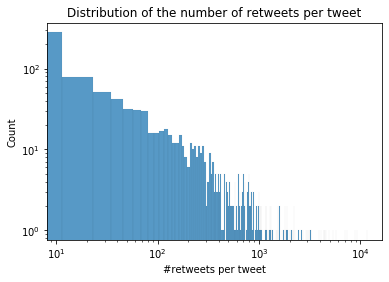

In [48]:
sns.histplot(number_retweets, bins = 1000)
plt.xscale('log')
plt.yscale('log')
plt.xlabel("#retweets per tweet")
plt.title('Distribution of the number of retweets per tweet')
plt.show()

In [49]:
ll = []
for rts in l :
    for user in rts : 
        ll.append(user)

targets = set(ll)

In [61]:
lset = [set(rts) for rts in l]

In [105]:
JI = np.zeros((NB_TWEETS, NB_TWEETS))
sets = np.zeros((NB_TWEETS, NB_TWEETS, 3))
corr = np.zeros((NB_TWEETS, NB_TWEETS))

for i in range(NB_TWEETS) :
    for j in range(i+1) :
        sets[i,j,0] = number_retweets[i]
        sets[i,j,1] = number_retweets[j]
        sets[i,j,2] = len( lset[i].intersection(lset[j]) )
        JI[i, j] = np.log(1 + sets[i,j,2] / len( lset[i].union( lset[j] ) ) )
        corr[i,j] = np.log( 1 + sets[i,j,2] / min( sets[i,j,0], sets[i,j,1] ) )



Community analysis : are all the cascades disjoint ?

In [109]:
"""
fusions[i] = list of all tweets <= i having at least one target in common with tweet i
"""
fusions = [list(np.arange(0, NB_TWEETS)[(sets[k,:,2] > 0)]) for k in range(NB_TWEETS)]
fusions[0] = [0]
fusions

[[0],
 [1],
 [2],
 [2, 3],
 [1, 4],
 [1, 2, 4, 5],
 [6],
 [7],
 [1, 8],
 [1, 9],
 [1, 2, 4, 5, 6, 10],
 [1, 2, 4, 10, 11],
 [12],
 [13],
 [1, 2, 5, 10, 11, 14],
 [3, 6, 15],
 [1, 2, 4, 5, 10, 11, 14, 15, 16],
 [4, 17],
 [15, 18],
 [19],
 [20],
 [21],
 [1, 10, 14, 22],
 [1, 2, 4, 10, 11, 14, 16, 22, 23],
 [1, 12, 16, 24],
 [10, 14, 15, 16, 25],
 [16, 26],
 [27],
 [4, 10, 14, 15, 16, 28],
 [10, 23, 29],
 [30],
 [1, 2, 4, 5, 10, 11, 14, 15, 16, 20, 22, 23, 24, 25, 28, 30, 31],
 [32],
 [33],
 [4, 12, 15, 25, 26, 31, 34],
 [13, 23, 31, 35],
 [1, 4, 6, 10, 11, 14, 15, 22, 25, 31, 36],
 [4, 5, 15, 16, 23, 31, 37],
 [38],
 [15, 23, 31, 39],
 [1, 2, 4, 10, 11, 14, 16, 22, 23, 31, 40],
 [41],
 [42],
 [11, 31, 40, 43],
 [44],
 [45],
 [46],
 [47],
 [48],
 [49],
 [4, 15, 50],
 [51],
 [52],
 [4, 5, 10, 15, 16, 24, 31, 36, 50, 53],
 [50, 54],
 [36, 55],
 [1, 2, 4, 6, 10, 11, 14, 15, 22, 24, 31, 36, 39, 53, 56],
 [57],
 [1, 14, 25, 58],
 [6, 15, 16, 22, 25, 30, 31, 36, 39, 53, 56, 59],
 [53, 56, 60],


In [ ]:
g = nx.Graph()
g.add_nodes_from(list(range(NB_TWEETS)))
for i in range(NB_TWEETS) : 
    for x in fusions[i] : 
        if x != i :
            g.add_edge(i, x)
nx.write_gexf(g, "graphs/communities.gexf")
cc = nx.connected_components(g)
"""
maximum connected component has 920/1000 nodes
"""

Influence prediction matrix

In [15]:
""" 
make file with :
user : id of cascades he participates in

 """
NB_TWEETS = 100
NB_RT_MAX_PER_TWEET = np.inf
def empty_list(): return []
users_cascades = defaultdict(empty_list)

with open("data/weibo/weibodata/diffusion/repost_data.txt", 'r') as file :
    remaining_nb_of_rt = 0
    l = []
    rts = []
    i=0
    for line in file.readlines() : 
        if i > NB_TWEETS : break

        if remaining_nb_of_rt == 0 :
            j = 0
            i+=1
            if i % (NB_TWEETS//10) == 0 : 
                print(f"{i / (NB_TWEETS//100)}%")
            remaining_nb_of_rt = int(line.replace('\n', '').split('\t')[1])
        else : 
            j += 1
            user  = int(line.replace('\n', '').split('\t')[1])
            if j < NB_RT_MAX_PER_TWEET :
                users_cascades[user].append(i)
            remaining_nb_of_rt -= 1

 

10.0%
20.0%
30.0%
40.0%
50.0%
60.0%
70.0%
80.0%
90.0%
100.0%


In [16]:
len(users_cascades.keys())

40080

76